## 2-Qubit Randomized Benchmarking
---
**John A. Smolin, David McKay, Yael Ben-Haim and Shelly Garion**


* **Last Updated:** Feb 13, 2019
* **Requires:** qiskit-terra 0.7

This notebook generates sequences for running 2-qubit randomized benchmarking. 


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error

import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))

# Import the RB Functions
import qiskit_ignis.randomized_benchmarking.standard_rb.randomizedbenchmarking as rb

#import the RB fitter
import qiskit_ignis.randomized_benchmarking.standard_rb.rb_fitters as rb_fitters

## Select the Parameters of the RB Run

In [8]:
#number of qubits
nQ = 2
#number of seeds (random sequences)
nseeds = 5
#number of Cliffords in the sequence (start, stop, steps)
nCliffs = np.arange(1,200,20)

## Generate RB sequences

We generate RB sequences. We start a small example (so it doesn't take too long to run). 

In [9]:
rb_opts = {}
rb_opts['length_vector'] = nCliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = [range(nQ)]
rb_opts['n_qubits'] = nQ
rb_circs, xdata, rb_opts = rb.randomized_benchmarking_seq(rb_opts)

Making the n=2 Clifford Table


As an example, we print the circuit corresponding to the first RB sequence

In [20]:
print(rb_circs[0])

         ┌───┐┌─────┐┌───┐┌─────┐┌───┐     ┌───┐ ░ ┌───┐        ┌───┐┌───┐┌───┐»
qr_0: |0>┤ H ├┤ Sdg ├┤ H ├┤ Sdg ├┤ H ├──■──┤ Z ├─░─┤ Z ├──■─────┤ H ├┤ S ├┤ H ├»
         └───┘└─────┘└───┘└─────┘└───┘┌─┴─┐└───┘ ░ └───┘┌─┴─┐┌─┐└───┘└───┘└───┘»
qr_1: |0>─────────────────────────────┤ X ├──────░──────┤ X ├┤M├───────────────»
                                      └───┘      ░      └───┘└╥┘               »
 cr_0: 0 ═════════════════════════════════════════════════════╬════════════════»
                                                              ║                »
 cr_1: 0 ═════════════════════════════════════════════════════╩════════════════»
                                                                               »
«      ┌───┐┌───┐┌─┐
«qr_0: ┤ S ├┤ H ├┤M├
«      └───┘└───┘└╥┘
«qr_1: ───────────╫─
«                 ║ 
«cr_0: ═══════════╩═
«                   
«cr_1: ═════════════
«                   


## Define the noise model

We define a noise model for the simulator. To simulate decay, we add depolarizing error probabilities to the CNOT and U gates.

In [10]:
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.002, 1), ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.002, 2), 'cx')

## Execute on Aer simulator

In [11]:
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = 'u1,u2,u3,cx' # use U,CX for now
shots = 1024
job = qiskit.execute(rb_circs, backend=backend, basis_gates=basis_gates, shots=shots, noise_model=noise_model)
result = job.result()

## Get statistics about the survival probabilities

In [12]:
raw_data = rb_fitters.calc_raw_data(result, rb_circs, rb_opts, shots)
ydata = rb_fitters.calc_statistics(raw_data)

## Fit an exponential curve

In [13]:
fit = rb_fitters.calc_rb_fit(xdata, ydata, rb_opts['rb_pattern'])

## Plot

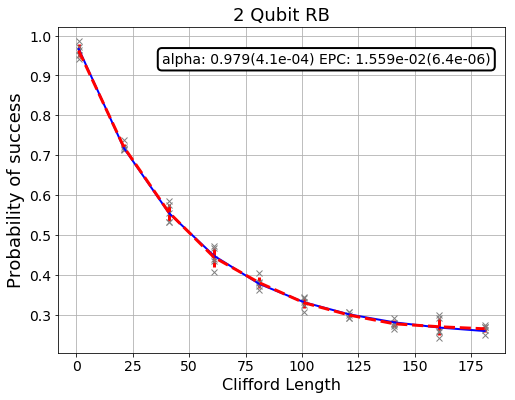

In [14]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rb_fitters.plot_rb_data(0, raw_data, xdata, ydata, fit, ax=ax, show_plt=False)

# Add title and label
ax.set_title('%d Qubit RB'%(nQ), fontsize=18)
ax.set_ylabel('Probability of success', fontsize=18)
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=2)

# Add more information
ax.text(0.6, 0.9,
        "alpha: %.3f(%.1e) EPC: %.3e(%.1e)"
        %(fit[0]['params'][1], fit[0]['params_err'][1], 
          fit[0]['epc'], fit[0]['epc_err']),
        ha="center", va="center", size=14, bbox=bbox_props, transform=ax.transAxes)

plt.show()